# GCN for DAVIS 2016

In this notebook, a custom [PyTorch Geometric](https://rusty1s.github.io/pytorch_geometric/build/html/index.html) [InMemoryDataset](https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric/data/in_memory_dataset.html#InMemoryDataset) for the DAVIS 2016 dataset is created. The implementation is based on this [tutorial](https://rusty1s.github.io/pytorch_geometric/build/html/notes/create_dataset.html). The dataset is then used to train a simple GCN network as a first evaluation based on this [tutorial](https://rusty1s.github.io/pytorch_geometric/build/html/notes/introduction.html#learning-methods-on-graphs).

The dataset consists of single PyTorch Geometric [Data](https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric/data/data.html#Data) objects which model a single graph with various attributes. For this dataset, a graph for each contour is created. Hereby, each node of the graph represents one contour point. The feature of each node is the OSVOS feature vector from the next frame at this point. Each node is connected to its K nearest neighbours. The feature of each edge is the distance between the nodes it connects. The targets of each node is the translation it undergoes from the current to the next frame.

## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torch.utils.data.sampler import SequentialSampler

from torch_geometric.data import DataLoader

from pg_datasets.davis_2016 import DAVIS2016
from pg_networks.gcn import GCN
from pg_solvers.solver import Solver
from pg_utils.vis_utils import show_img_with_contour, plot_translation, show_loss

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Paths & Constants

In [2]:
PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH = 'pg_datasets/DAVIS_2016'#'pg_datasets/DAVIS_2016'
CONTOURS_FOLDERS_PATH = 'DAVIS_2016/DAVIS/Contours/480p'
IMAGES_FOLDERS_PATH = 'DAVIS_2016/DAVIS/JPEGImages/480p'
TRANSLATIONS_FOLDERS_PATH = 'DAVIS_2016/DAVIS/Translations/480p'

SKIP_SEQUENCES = []

SKIP_SEQUENCES = ['bmx-trees', 'bus', 'cows', 'dog-agility', 'horsejump-high', 
                  'horsejump-low', 'kite-walk', 'lucia', 'libby', 'motorbike',
                  'paragliding', 'rhino', 'scooter-gray', 'swing']

TRAIN_SEQUENCES = ['bear', 'bmx-bumps', 'boat', 'breakdance-flare', 'bus', 
                   'car-turn', 'dance-jump', 'dog-agility', 'drift-turn', 
                   'elephant', 'flamingo', 'hike', 'hockey', 'horsejump-low', 
                   'kite-walk', 'lucia', 'mallard-fly', 'mallard-water', 
                   'motocross-bumps', 'motorbike', 'paragliding', 'rhino', 
                   'rollerblade', 'scooter-gray', 'soccerball', 'stroller',
                   'surf', 'swing', 'tennis', 'train']

VAL_SEQUENCES = ['blackswan', 'bmx-trees', 'breakdance', 'camel', 'car-roundabout',
                 'car-shadow', 'cows', 'dance-twirl', 'dog', 'drift-chicane', 
                 'drift-straight', 'goat', 'horsejump-high', 'kite-surf', 'libby', 
                 'motocross-jump', 'paragliding-launch', 'parkour', 'scooter-black', 
                 'soapbox']

BATCH_SIZE = 32
LAYER = 9
K = 32
EPOCHS_WO_AVEGRAD = 5

## Train and Val Dataset

In [3]:
train = DAVIS2016(PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH, 
                  CONTOURS_FOLDERS_PATH, IMAGES_FOLDERS_PATH, TRANSLATIONS_FOLDERS_PATH, 
                  LAYER, K, EPOCHS_WO_AVEGRAD,
                  SKIP_SEQUENCES, TRAIN_SEQUENCES, VAL_SEQUENCES,
                  train=True)

In [4]:
val = DAVIS2016(PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH, 
                CONTOURS_FOLDERS_PATH, IMAGES_FOLDERS_PATH, TRANSLATIONS_FOLDERS_PATH, 
                LAYER, K, EPOCHS_WO_AVEGRAD,
                SKIP_SEQUENCES, TRAIN_SEQUENCES, VAL_SEQUENCES,
                train=False)

In [ ]:
print("Train size: %i" % len(train))
print("Val size: %i" % len(val))

Train size: 1357
Val size: 1061


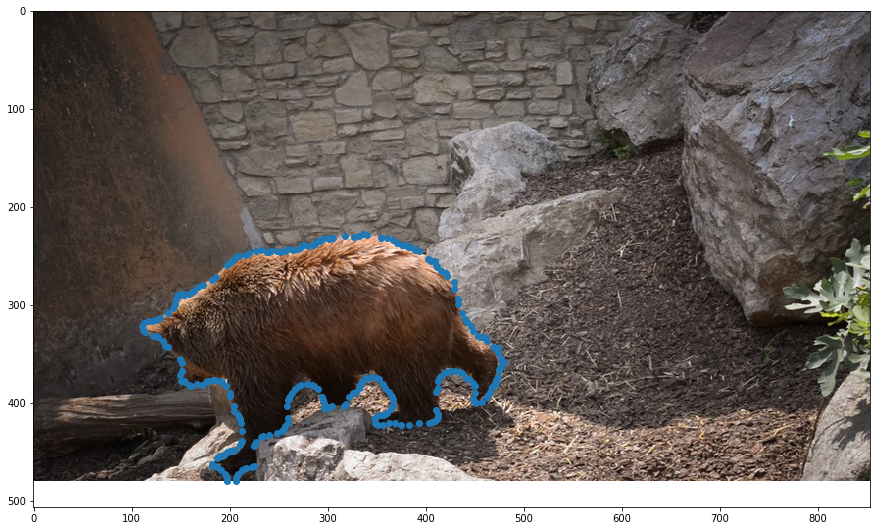

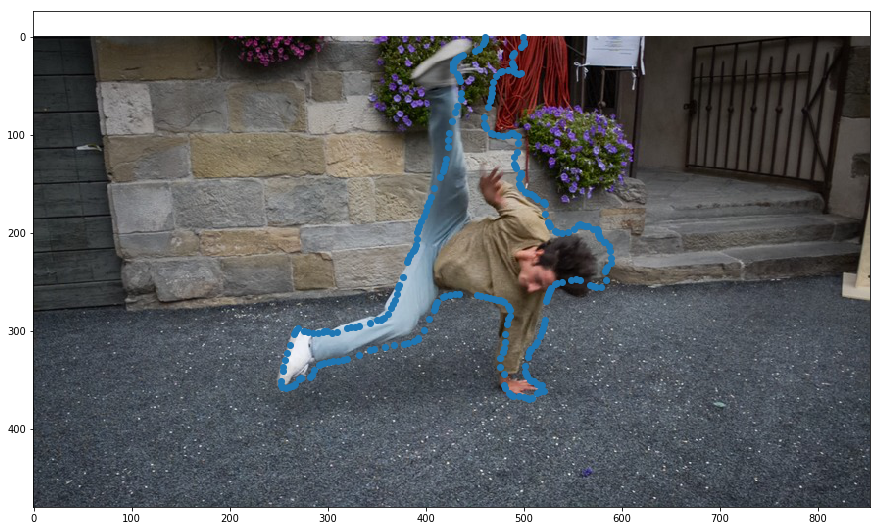

In [ ]:
num_to_display = 2

for i in range(num_to_display):
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(train))
    sample = train[rand_i]
    show_img_with_contour(sample)

## Simple GCN

In [ ]:
model = GCN(in_channels=train[0].num_features, 
            out_channels=train[0].y.shape[1])

print(model)

GCN(
  (conv1): GCNConv(256, 512)
  (conv2): GCNConv(512, 512)
  (conv3): GCNConv(512, 1024)
  (lin1): Linear(in_features=1024, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=2, bias=True)
)


### Overfit

In [ ]:
num_train = 80
num_val = 20

overfit_train_loader = DataLoader(train, batch_size=16, 
                                  shuffle=False, sampler=SequentialSampler(range(num_train)))
overfit_val_loader = DataLoader(train, batch_size=1, 
                                shuffle=False, sampler=SequentialSampler(range(num_val)))

# Load model and run the solver
overfit_model = GCN(in_channels=train[0].num_features, 
                    out_channels=train[0].y.shape[1])

overfit_solver = Solver(optim_args={"lr": 1e-4})
overfit_solver.train(overfit_model, overfit_train_loader, overfit_val_loader,
                     num_epochs=20, log_nth=100, verbose=True)

START TRAIN.
[Epoch 1/20] train_loss: 87.85790 - val_loss: 8.80498
[Epoch 2/20] train_loss: 6.35720 - val_loss: 8.82964
[Epoch 3/20] train_loss: 5.66620 - val_loss: 8.07271
[Epoch 4/20] train_loss: 5.23810 - val_loss: 7.86255
[Epoch 5/20] train_loss: 4.90946 - val_loss: 7.81964
[Epoch 6/20] train_loss: 4.74354 - val_loss: 7.53517
[Epoch 7/20] train_loss: 4.55757 - val_loss: 7.34789
[Epoch 8/20] train_loss: 4.37970 - val_loss: 7.26704
[Epoch 9/20] train_loss: 4.25112 - val_loss: 7.13165
[Epoch 10/20] train_loss: 4.12345 - val_loss: 6.98662
[Epoch 11/20] train_loss: 4.00599 - val_loss: 6.90055
[Epoch 12/20] train_loss: 3.91687 - val_loss: 6.79982
[Epoch 13/20] train_loss: 3.83106 - val_loss: 6.70835
[Epoch 14/20] train_loss: 3.75849 - val_loss: 6.62427
[Epoch 15/20] train_loss: 3.69110 - val_loss: 6.53758
[Epoch 16/20] train_loss: 3.62917 - val_loss: 6.45235
[Epoch 17/20] train_loss: 3.56545 - val_loss: 6.37464
[Epoch 18/20] train_loss: 3.50650 - val_loss: 6.28733
[Epoch 19/20] train_los

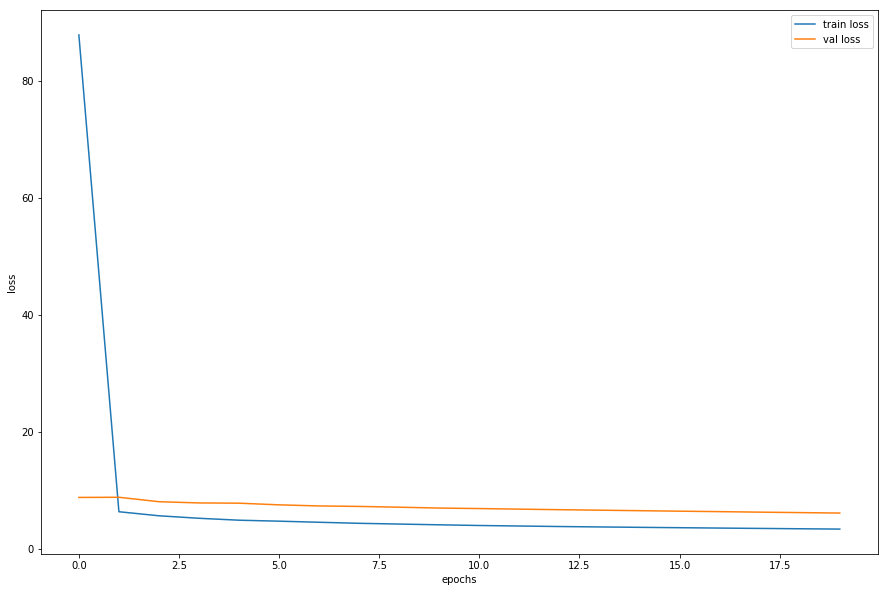

In [ ]:
show_loss(overfit_solver)

13


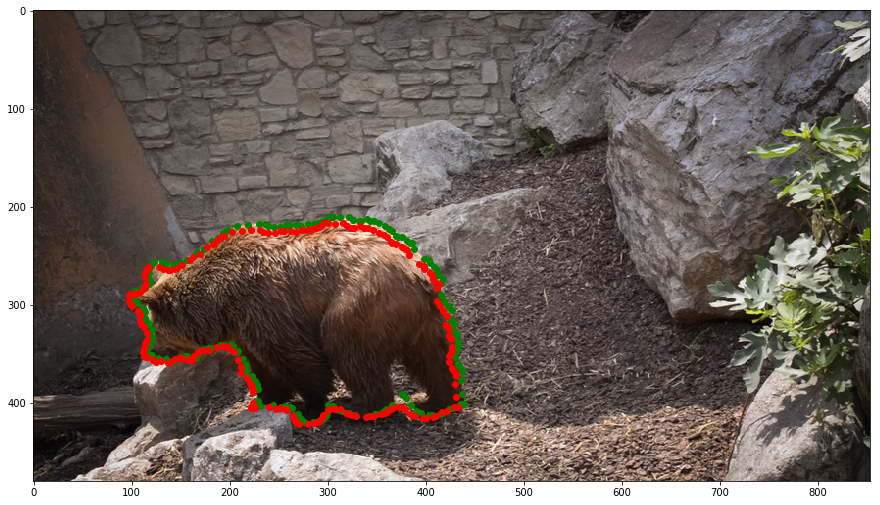

12


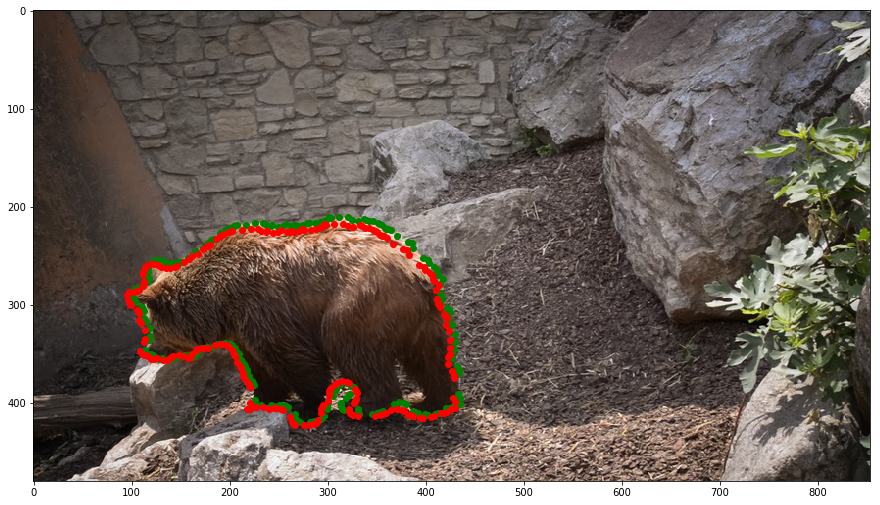

In [ ]:
model.cpu()
model.double()
model.eval()
num_to_display = 2

for i in range(num_to_display):
    
    rand_i = np.random.randint(0, num_val)
    print(rand_i)
    sample = train[rand_i]
    
    img = sample.img.detach().numpy().astype(np.int64)
    img = np.squeeze(img)
    img = np.moveaxis(img, 0, 2)
    
    translation = sample.y.detach().numpy()
    
    contour = sample.contour.detach().numpy()

    with torch.no_grad():
        pred_translation = model(sample).detach().numpy()

    translation_ground_truth = contour + translation
    translation_pred = contour + pred_translation
    
    plot_translation(img, translation_ground_truth, translation_pred)

### Train

In [ ]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)

# Load model and run the solver
model = GCN(in_channels=train[0].num_features, 
            out_channels=train[0].y.shape[1])

solver = Solver(optim_args={"lr": 1e-4})

solver.train(model, train_loader, val_loader,
             num_epochs=20, log_nth=5, verbose=True)

START TRAIN.
[Iteration 5/43] loss: 271.376
[Iteration 10/43] loss: 372.205
[Iteration 15/43] loss: 379.020
[Iteration 20/43] loss: 233.934
[Iteration 25/43] loss: 239.167
[Iteration 30/43] loss: 238.680
[Iteration 35/43] loss: 225.952
[Iteration 40/43] loss: 248.901
[Epoch 1/20] train_loss: 272.44908 - val_loss: 252.80621
[Iteration 5/43] loss: 288.181
[Iteration 10/43] loss: 328.962
[Iteration 15/43] loss: 204.494
[Iteration 20/43] loss: 279.916
[Iteration 25/43] loss: 207.414
[Iteration 30/43] loss: 352.456
[Iteration 35/43] loss: 177.761
[Iteration 40/43] loss: 197.470
[Epoch 2/20] train_loss: 258.08730 - val_loss: 254.14812
[Iteration 5/43] loss: 251.880
[Iteration 10/43] loss: 258.087
[Iteration 15/43] loss: 267.358
[Iteration 20/43] loss: 228.865
[Iteration 25/43] loss: 201.641
[Iteration 30/43] loss: 293.201
[Iteration 35/43] loss: 259.268
[Iteration 40/43] loss: 206.900
[Epoch 3/20] train_loss: 241.95650 - val_loss: 254.43791
[Iteration 5/43] loss: 326.585
[Iteration 10/43] lo

In [ ]:
show_loss(solver)

### Display trained outputs

In [ ]:
model.cpu()
num_to_display = 2
for i in range(num_to_display):
    
    rand_i = np.random.randint(0, len(val))
    sample = val[rand_i]
    
    img = sample.img.detach().numpy().astype(np.int64)
    img = np.squeeze(img)
    img = np.moveaxis(img, 0, 2)
    
    translation = sample.y.detach().numpy()
    
    contour = sample.contour.detach().numpy()

    with torch.no_grad():
        pred_translation = model(sample).detach().numpy()

    translation_ground_truth = contour + translation
    translation_pred = contour + pred_translation
    
    plot_translation(img, translation_ground_truth, translation_pred)